# Creating Keras DNN model

**Learning Objectives**

1. Create input layers for raw features
1. Create feature columns for inputs
1. Create DNN dense hidden layers and output layer
1. Build DNN model tying all of the pieces together
1. Train and evaluate


## Introduction 
In this notebook, we'll be using Keras to create a DNN model to predict the weight of a baby before it is born.

We'll start by defining the CSV column names, label column, and column defaults for our data inputs. Then, we'll construct a tf.data Dataset of features and the label from the CSV files and create inputs layers for the raw features. Next, we'll set up feature columns for the model inputs and build a deep neural network in Keras. We'll create a custom evaluation metric and build our DNN model. Finally, we'll train and evaluate our model.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive2/end_to_end_ml/solutions/keras_dnn_babyweight.ipynb).

## Set up environment variables and load necessary libraries

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 KB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 2.2.1 requires google-resumable-media>=2.3.2, but you have google-resumable-media 0.5.1 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.41.0 which is incompatible.


**Note**: Restart your kernel to use updated packages.

Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

Import necessary libraries.

In [35]:
from google.cloud import bigquery
import pandas as pd
import datetime
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.6.3


Set environment variables so that we can use them throughout the notebook.

In [36]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: qwiklabs-gcp-01-f6ea9a83f3d5


In [48]:
PROJECT = "qwiklabs-gcp-01-f6ea9a83f3d5"  # Replace with your PROJECT

## Create ML datasets by sampling using BigQuery

We'll begin by sampling the BigQuery data to create smaller datasets. Let's create a BigQuery client that we'll use throughout the lab.

In [49]:
bq = bigquery.Client(project = PROJECT)

We need to figure out the right way to divide our hash values to get our desired splits. To do that we need to define some values to hash within the module. Feel free to play around with these values to get the perfect combination.

In [50]:
modulo_divisor = 100
train_percent = 80.0
eval_percent = 10.0

train_buckets = int(modulo_divisor * train_percent / 100.0)
eval_buckets = int(modulo_divisor * eval_percent / 100.0)

We can make a series of queries to check if our bucketing values result in the correct sizes of each of our dataset splits and then adjust accordingly. Therefore, to make our code more compact and reusable, let's define a function to return the head of a dataframe produced from our queries up to a certain number of rows.

In [51]:
def display_dataframe_head_from_query(query, count=10):
    """Displays count rows from dataframe head from query.
    
    Args:
        query: str, query to be run on BigQuery, results stored in dataframe.
        count: int, number of results from head of dataframe to display.
    Returns:
        Dataframe head with count number of results.
    """
    df = bq.query(
        query + " LIMIT {limit}".format(
            limit=count)).to_dataframe()

    return df.head(count)

For our first query, we're going to use the original query above to get our label, features, and columns to combine into our hash which we will use to perform our repeatable splitting. There are only a limited number of years, months, days, and states in the dataset. Let's see what the hash values are. We will need to include all of these extra columns to hash on to get a fairly uniform spread of the data. Feel free to try less or more in the hash and see how it changes your results.

In [ ]:
# Get label, features, and columns to hash and split into buckets
hash_cols_fixed_query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    year,
    month,
    CASE
        WHEN day IS NULL THEN
            CASE
                WHEN wday IS NULL THEN 0
                ELSE wday
            END
        ELSE day
    END AS date,
    IFNULL(state, "Unknown") AS state,
    IFNULL(mother_birth_state, "Unknown") AS mother_birth_state
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0
"""

display_dataframe_head_from_query(hash_cols_fixed_query)

Using `COALESCE` would provide the same result as the nested `CASE WHEN`. This is preferable when all we want is the first non-null instance. To be precise the `CASE WHEN` would become `COALESCE(wday, day, 0) AS date`. You can read more about it [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/conditional_expressions).

Next query will combine our hash columns and will leave us just with our label, features, and our hash values.

In [52]:
data_query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    FARM_FINGERPRINT(
        CONCAT(
            CAST(year AS STRING),
            CAST(month AS STRING),
            CAST(date AS STRING),
            CAST(state AS STRING),
            CAST(mother_birth_state AS STRING)
        )
    ) AS hash_values
FROM
    ({CTE_hash_cols_fixed})
""".format(CTE_hash_cols_fixed=hash_cols_fixed_query)

display_dataframe_head_from_query(data_query)

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,7.568469,True,22,1,46,8215786142059938346
1,8.807467,True,39,1,42,-3743460808742532334
2,8.313632,True,23,1,35,3085340672249953670
3,8.000575,False,27,1,40,-8977248512766122915
4,6.563162,False,29,1,39,3569825836188555148
5,7.125340,False,34,1,40,-8870304296601831012
6,7.438397,False,31,1,38,-6831288907654995035
7,7.352416,True,30,1,37,5750188026412175912
8,8.062305,True,16,1,40,-1538384778382862403
9,7.251004,True,17,1,39,3493115208516616154


The next query is going to find the counts of each of the unique 657484 `hash_values`. This will be our first step at making actual hash buckets for our split via the `GROUP BY`.

In [ ]:
# Get the counts of each of the unique hash of our splitting column
first_bucketing_query = """
SELECT
    hash_values,
    COUNT(*) AS num_records
FROM
    ({CTE_data})
GROUP BY
    hash_values
""".format(CTE_data=data_query)

display_dataframe_head_from_query(first_bucketing_query)

The query below performs a second layer of bucketing where now for each of these bucket indices we count the number of records.

In [43]:
# Get the number of records in each of the hash buckets
second_bucketing_query = """
SELECT
    ABS(MOD(hash_values, {modulo_divisor})) AS bucket_index,
    SUM(num_records) AS num_records
FROM
    ({CTE_first_bucketing})
GROUP BY
    ABS(MOD(hash_values, {modulo_divisor}))
""".format(
    CTE_first_bucketing=first_bucketing_query, modulo_divisor=modulo_divisor)

display_dataframe_head_from_query(second_bucketing_query)

NameError: name 'first_bucketing_query' is not defined

The number of records is hard for us to easily understand the split, so we will normalize the count into percentage of the data in each of the hash buckets in the next query.

In [ ]:
# Calculate the overall percentages
percentages_query = """
SELECT
    bucket_index,
    num_records,
    CAST(num_records AS FLOAT64) / (
    SELECT
        SUM(num_records)
    FROM
        ({CTE_second_bucketing})) AS percent_records
FROM
    ({CTE_second_bucketing})
""".format(CTE_second_bucketing=second_bucketing_query)

display_dataframe_head_from_query(percentages_query)

We'll now select the range of buckets to be used in training.

In [ ]:
# Choose hash buckets for training and pull in their statistics
train_query = """
SELECT
    *,
    "train" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= 0
    AND bucket_index < {train_buckets}
""".format(
    CTE_percentages=percentages_query,
    train_buckets=train_buckets)

display_dataframe_head_from_query(train_query)

We'll do the same by selecting the range of buckets to be used evaluation.

In [ ]:
# Choose hash buckets for validation and pull in their statistics
eval_query = """
SELECT
    *,
    "eval" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= {train_buckets}
    AND bucket_index < {cum_eval_buckets}
""".format(
    CTE_percentages=percentages_query,
    train_buckets=train_buckets,
    cum_eval_buckets=train_buckets + eval_buckets)

display_dataframe_head_from_query(eval_query)

Lastly, we'll select the hash buckets to be used for the test split.

In [16]:
# Choose hash buckets for testing and pull in their statistics
test_query = """
SELECT
    *,
    "test" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= {cum_eval_buckets}
    AND bucket_index < {modulo_divisor}
""".format(
    CTE_percentages=percentages_query,
    cum_eval_buckets=train_buckets + eval_buckets,
    modulo_divisor=modulo_divisor)

display_dataframe_head_from_query(test_query)

,bucket_index,num_records,percent_records,dataset_name
0,94,431001,0.013056,test
1,91,333267,0.010096,test
2,97,480790,0.014564,test
3,98,374697,0.011351,test
4,96,529357,0.016036,test
5,99,223334,0.006765,test
6,95,313544,0.009498,test
7,92,336735,0.010201,test
8,90,286465,0.008678,test
9,93,215710,0.006534,test


In the below query, we'll `UNION ALL` all of the datasets together so that all three sets of hash buckets will be within one table. We added `dataset_id` so that we can sort on it in the query after.

In [17]:
# Union the training, validation, and testing dataset statistics
union_query = """
SELECT
    0 AS dataset_id,
    *
FROM
    ({CTE_train})
UNION ALL
SELECT
    1 AS dataset_id,
    *
FROM
    ({CTE_eval})
UNION ALL
SELECT
    2 AS dataset_id,
    *
FROM
    ({CTE_test})
""".format(CTE_train=train_query, CTE_eval=eval_query, CTE_test=test_query)

display_dataframe_head_from_query(union_query)

,dataset_id,bucket_index,num_records,percent_records,dataset_name
0,0,42,405587,0.012286,train
1,0,34,379000,0.011481,train
2,0,49,468121,0.014181,train
3,0,7,270933,0.008207,train
4,0,27,355234,0.010761,train
5,0,78,326758,0.009898,train
6,0,24,352559,0.010680,train
7,0,31,220366,0.006675,train
8,0,37,295153,0.008941,train
9,0,13,274104,0.008303,train


Lastly, we'll show the final split between train, eval, and test sets. We can see both the number of records and percent of the total data. It is really close to that we were hoping to get.

In [18]:
# Show final splitting and associated statistics
split_query = """
SELECT
    dataset_id,
    dataset_name,
    SUM(num_records) AS num_records,
    SUM(percent_records) AS percent_records
FROM
    ({CTE_union})
GROUP BY
    dataset_id,
    dataset_name
ORDER BY
    dataset_id
""".format(CTE_union=union_query)

display_dataframe_head_from_query(split_query)

,dataset_id,dataset_name,num_records,percent_records
0,0,train,25873134,0.783765
1,1,eval,3613325,0.109457
2,2,test,3524900,0.106778


Now that we know that our splitting values produce a good global splitting on our data, here's a way to get a well-distributed portion of the data in such a way that the train, eval, test sets do not overlap and takes a subsample of our global splits.

In [53]:
# every_n allows us to subsample from each of the hash values
# This helps us get approximately the record counts we want
every_n = 1000

splitting_string = "ABS(MOD(hash_values, {0} * {1}))".format(every_n, modulo_divisor)

def create_data_split_sample_df(query_string, splitting_string, lo, up):
    """Creates a dataframe with a sample of a data split.

    Args:
        query_string: str, query to run to generate splits.
        splitting_string: str, modulo string to split by.
        lo: float, lower bound for bucket filtering for split.
        up: float, upper bound for bucket filtering for split.
    Returns:
        Dataframe containing data split sample.
    """
    query = "SELECT * FROM ({0}) WHERE {1} >= {2} and {1} < {3}".format(
        query_string, splitting_string, int(lo), int(up))

    df = bq.query(query).to_dataframe()

    return df

train_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=0, up=train_percent)

eval_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=train_percent, up=train_percent + eval_percent)

test_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=train_percent + eval_percent, up=modulo_divisor)

print("There are {} examples in the train dataset.".format(len(train_df)))
print("There are {} examples in the validation dataset.".format(len(eval_df)))
print("There are {} examples in the test dataset.".format(len(test_df)))

There are 7733 examples in the train dataset.
There are 1037 examples in the validation dataset.
There are 561 examples in the test dataset.


## Preprocess data using Pandas

We'll perform a few preprocessing steps to the data in our dataset. Let's add extra rows to simulate the lack of ultrasound. That is we'll duplicate some rows and make the `is_male` field be `Unknown`. Also, if there is more than child we'll change the `plurality` to `Multiple(2+)`. While we're at it, we'll also change the plurality column to be a string. We'll perform these operations below. 

Let's start by examining the training dataset as is.

In [54]:
train_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,5.937049,True,23,1,39,-6784884401981100070
1,7.374463,True,28,1,38,-1792211462198300014
2,7.810978,True,22,1,42,-2473233337125700055
3,8.999270,True,21,1,38,6567453535821100019
4,6.250105,True,19,1,37,4896699230184800022


Also, notice that there are some very important numeric fields that are missing in some rows (the count in Pandas doesn't count missing data)

In [55]:
train_df.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,hash_values
count,7733.000000,7733.000000,7733.000000,7733.000000,7.733000e+03
mean,7.264415,28.213371,1.035691,38.691064,-2.984870e+17
std,1.303220,6.134232,0.201568,2.531921,5.590715e+18
min,0.562179,13.000000,1.000000,18.000000,-9.210618e+18
25%,6.624891,23.000000,1.000000,38.000000,-6.781866e+18
50%,7.345803,28.000000,1.000000,39.000000,5.057323e+17
75%,8.062305,33.000000,1.000000,40.000000,4.896699e+18
max,11.563246,48.000000,4.000000,47.000000,9.203641e+18


It is always crucial to clean raw data before using in machine learning, so we have a preprocessing step. We'll define a `preprocess` function below. Note that the mother's age is an input to our model so users will have to provide the mother's age; otherwise, our service won't work. The features we use for our model were chosen because they are such good predictors and because they are easy enough to collect.

In [56]:
def preprocess(df):
    """ Preprocess pandas dataframe for augmented babyweight data.
    
    Args:
        df: Dataframe containing raw babyweight data.
    Returns:
        Pandas dataframe containing preprocessed raw babyweight data as well
            as simulated no ultrasound data masking some of the original data.
    """
    # Clean up raw data
    # Filter out what we don"t want to use for training
    df = df[df.weight_pounds > 0]
    df = df[df.mother_age > 0]
    df = df[df.gestation_weeks > 0]
    df = df[df.plurality > 0]

    # Modify plurality field to be a string
    twins_etc = dict(zip([1,2,3,4,5],
                   ["Single(1)",
                    "Twins(2)",
                    "Triplets(3)",
                    "Quadruplets(4)",
                    "Quintuplets(5)"]))
    df["plurality"].replace(twins_etc, inplace=True)

    # Clone data and mask certain columns to simulate lack of ultrasound
    no_ultrasound = df.copy(deep=True)

    # Modify is_male
    no_ultrasound["is_male"] = "Unknown"
    
    # Modify plurality
    condition = no_ultrasound["plurality"] != "Single(1)"
    no_ultrasound.loc[condition, "plurality"] = "Multiple(2+)"

    # Concatenate both datasets together and shuffle
    return pd.concat(
        [df, no_ultrasound]).sample(frac=1).reset_index(drop=True)

Let's process the train, eval, test set and see a small sample of the training data after our preprocessing:

In [57]:
train_df = preprocess(train_df)
eval_df = preprocess(eval_df)
test_df = preprocess(test_df)

In [58]:
train_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,6.812284,Unknown,22,Multiple(2+),38,4896699230184800022
1,7.874912,False,22,Single(1),39,780565305641800050
2,7.625790,Unknown,28,Single(1),39,-6784884401981100070
3,6.686620,Unknown,25,Single(1),40,7874607970250900031
4,6.686620,False,34,Single(1),38,-3045973789445800058


In [59]:
train_df.tail()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
15461,8.146081,Unknown,25,Single(1),40,8720767384765100051
15462,5.189682,True,19,Single(1),37,3835474516102300019
15463,6.624891,False,29,Single(1),36,-8422275538947500071
15464,6.382382,Unknown,35,Single(1),40,632361545655800049
15465,8.000575,True,22,Single(1),40,-6784884401981100070


Let's look again at a summary of the dataset. Note that we only see numeric columns, so `plurality` does not show up.

In [60]:
train_df.describe()

,weight_pounds,mother_age,gestation_weeks,hash_values
count,15466.000000,15466.000000,15466.000000,1.546600e+04
mean,7.264415,28.213371,38.691064,-2.984870e+17
std,1.303178,6.134034,2.531839,5.590534e+18
min,0.562179,13.000000,18.000000,-9.210618e+18
25%,6.624891,23.000000,38.000000,-6.781866e+18
50%,7.345803,28.000000,39.000000,5.057323e+17
75%,8.062305,33.000000,40.000000,4.896699e+18
max,11.563246,48.000000,47.000000,9.203641e+18


## Write to .csv files 

In the final versions, we want to read from files, not Pandas dataframes. So, we write the Pandas dataframes out as csv files. Using csv files gives us the advantage of shuffling during read. This is important for distributed training because some workers might be slower than others, and shuffling the data helps prevent the same data from being assigned to the slow workers.

In [61]:
# Define columns
columns = ["weight_pounds",
           "is_male",
           "mother_age",
           "plurality",
           "gestation_weeks"]

# Write out CSV files
train_df.to_csv(
    path_or_buf="train.csv", columns=columns, header=False, index=False)
eval_df.to_csv(
    path_or_buf="eval.csv", columns=columns, header=False, index=False)
test_df.to_csv(
    path_or_buf="test.csv", columns=columns, header=False, index=False)

In [62]:
%%bash
wc -l *.csv

  2074 eval.csv
  1122 test.csv
 15466 train.csv
 18662 total


In [63]:
%%bash
head *.csv

==> eval.csv <==
3.5604655312999998,Unknown,18,Single(1),33
5.06181353552,False,37,Twins(2),35
9.06320359082,Unknown,28,Single(1),39
8.75014717878,Unknown,34,Single(1),38
6.686620406459999,Unknown,27,Single(1),40
7.3744626639,True,30,Single(1),38
6.9996768185,Unknown,33,Single(1),40
6.87621795178,Unknown,31,Multiple(2+),44
8.86699217764,False,22,Single(1),38
7.06361087448,Unknown,22,Single(1),39

==> test.csv <==
8.375361333379999,True,26,Single(1),41
8.50102482272,False,34,Single(1),39
6.8784225744,Unknown,33,Single(1),40
1.6248068709399999,Unknown,41,Single(1),22
9.12493302418,Unknown,23,Single(1),41
7.936641432,False,36,Single(1),40
7.5287862473,Unknown,32,Single(1),37
7.936641432,Unknown,36,Single(1),40
10.56234697242,False,29,Single(1),36
7.06140625186,Unknown,23,Single(1),40

==> train.csv <==
6.8122838958,Unknown,22,Multiple(2+),38
7.87491199864,False,22,Single(1),39
7.62578964258,Unknown,28,Single(1),39
6.686620406459999,Unknown,25,Single(1),40
6.686620406459999,False,34,Single

In [64]:
%%bash
tail *.csv

==> eval.csv <==
7.5618555866,Unknown,32,Single(1),40
6.2501051276999995,False,38,Single(1),38
8.24308397618,Unknown,18,Single(1),34
7.3744626639,Unknown,34,Single(1),41
6.0627122049999995,False,26,Single(1),38
6.37576861704,Unknown,27,Single(1),39
7.25100379718,Unknown,33,Single(1),39
3.4612575134,True,20,Single(1),40
8.0248263368,False,32,Single(1),40
8.56275425608,False,30,Single(1),38

==> test.csv <==
8.62448368944,True,28,Single(1),39
4.9383546688,Unknown,29,Single(1),34
9.31232594688,True,27,Single(1),42
8.000575487979999,True,40,Single(1),38
8.9838371765,Unknown,34,Single(1),42
4.43790533406,Unknown,26,Multiple(2+),35
9.43798943622,Unknown,35,Single(1),41
5.56226287026,Unknown,38,Multiple(2+),35
5.8135898489399995,False,28,Single(1),38
6.6248909731,Unknown,22,Single(1),38

==> train.csv <==
7.8484565272,False,30,Single(1),41
6.77039606602,True,39,Single(1),38
8.575981991799999,Unknown,21,Single(1),39
7.25100379718,False,20,Single(1),35
7.7492485093,False,19,Single(1),41
8.14608

In [65]:
%%bash
ls *.csv

eval.csv
test.csv
train.csv


In [66]:
%%bash
head -5 *.csv

==> eval.csv <==
3.5604655312999998,Unknown,18,Single(1),33
5.06181353552,False,37,Twins(2),35
9.06320359082,Unknown,28,Single(1),39
8.75014717878,Unknown,34,Single(1),38
6.686620406459999,Unknown,27,Single(1),40

==> test.csv <==
8.375361333379999,True,26,Single(1),41
8.50102482272,False,34,Single(1),39
6.8784225744,Unknown,33,Single(1),40
1.6248068709399999,Unknown,41,Single(1),22
9.12493302418,Unknown,23,Single(1),41

==> train.csv <==
6.8122838958,Unknown,22,Multiple(2+),38
7.87491199864,False,22,Single(1),39
7.62578964258,Unknown,28,Single(1),39
6.686620406459999,Unknown,25,Single(1),40
6.686620406459999,False,34,Single(1),38


## Create Keras model

### Set CSV Columns, label column, and column defaults.

Now that we have verified that our CSV files exist, we need to set a few things that we will be using in our input function.
* `CSV_COLUMNS` is going to be our header name of our column. Make sure that they are in the same order as in the CSV files
* `LABEL_COLUMN` is the header name of the column that is our label / target variable. We will need to know this to pop it from our features dictionary.
* `DEFAULTS` is a list with the same length as `CSV_COLUMNS`, i.e. there is a default for each column in our CSVs. Each element is a list itself with the default value for that CSV column.

In [9]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks"]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

### Make dataset of features and label from CSV files.

Next, we will write an input_fn to read the data. Since we are reading from CSV files we can save ourselves from trying to recreate the wheel and can use `tf.data.experimental.make_csv_dataset`. This will create a CSV dataset object. However we will need to divide the columns up into features and a label. We can do this by applying the map method to our dataset and popping our label column off of our dictionary of feature tensors.

In [10]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)
    
    return row_data, label

In [11]:
def load_dataset(pattern: str, batch_size: int = 1, mode: str = 'eval') -> tf.data.Dataset:
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: 'train' | 'eval' to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        ignore_errors=True)
    
    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)
    
    # Shuffle dataset and repeat if training
    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()
        
    # Multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset

In [12]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode='eval'):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: 'train' | 'eval' to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        ignore_errors=True)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### Create input layers for raw features.

We'll need to get the data to read in by our input function to our model function, but just how do we go about connecting the dots? We can use Keras input layers [(tf.Keras.layers.Input)](https://www.tensorflow.org/api_docs/python/tf/keras/Input) by defining:
* shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
* name: An optional name string for the layer. Should be unique in a model (do not reuse the same name twice). It will be autogenerated if it isn't provided.
* dtype: The data type expected by the input, as a string (float32, float64, int32...)

**Lab Task #1:** Creating input layers for raw features.

In [13]:
from tensorflow.keras import Input

In [21]:
# TODO 1
def create_input_layers():
    X = {}
    # create a dictionary of colname: Input()
    X["is_male"] = Input(shape=(None,), dtype="string", name="is_male")
    X["plurality"] = Input(shape=(None,), dtype="string", name="plurality")
    X["mother_age"] = Input(shape=(None,), dtype="float32", name="mother_age")
    X["gestation_weeks"] = Input(shape=(None,), dtype="float32", name="gestation_weeks")

    return X

In [22]:
create_input_layers()

{'is_male': <KerasTensor: shape=(None, None) dtype=string (created by layer 'is_male')>,
 'plurality': <KerasTensor: shape=(None, None) dtype=string (created by layer 'plurality')>,
 'mother_age': <KerasTensor: shape=(None, None) dtype=float32 (created by layer 'mother_age')>,
 'gestation_weeks': <KerasTensor: shape=(None, None) dtype=float32 (created by layer 'gestation_weeks')>}

### Create feature columns for inputs.

Next, define the feature columns. `mother_age` and `gestation_weeks` should be numeric. The others, `is_male` and `plurality`, should be categorical. Remember, only dense feature columns can be inputs to a DNN.

**Lab Task #2:** Creating feature columns.

In [24]:
CSV_COLUMNS

['weight_pounds', 'is_male', 'mother_age', 'plurality', 'gestation_weeks']

In [32]:
# TODO 2
def get_categorical(name, values):
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key=name, vocabulary_list=values)
    
    return tf.feature_column.indicator_column(cat_col)

def create_feature_columns():
    feature_cols = {}
    feature_cols["is_male"] = get_categorical("is_male", ["True", "False", "Unknown"])
    feature_cols["plurality"] = get_categorical("plurality", ["Single(1)", "Twins(2)", "Triplets(3)",
                                                              "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])
    
    feature_cols["mother_age"] = tf.feature_column.numeric_column("mother_age")
    feature_cols["gestation_weeks"] = tf.feature_column.numeric_column("gestation_weeks")
    
    return feature_cols

### Create DNN dense hidden layers and output layer.

So we've figured out how to get our inputs ready for machine learning but now we need to connect them to our desired output. Our model architecture is what links the two together. Let's create some hidden dense layers beginning with our inputs and end with a dense output layer. This is regression so make sure the output layer activation is correct and that the shape is right.

**Lab Task #3:** Creating DNN dense hidden layers.

In [28]:
# TODO 3
def get_model_outputs(inputs):
    """Creates model architecture and returns outputs.

    Args:
        inputs: Dense tensor used as inputs to model.
    Returns:
        Dense tensor output from the model.
    """
    # Create two hidden layers of [64, 32] just in like the BQML DNN
    # TODO -- Your code here.
    h1 = tf.keras.layers.Dense(units=64, activation="relu", name="h1")(inputs)
    h2 = tf.keras.layers.Dense(units=32, activation="relu", name="h2")(h1)
    
    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(
        units=1, activation="linear", name="weight")(h2)

    return output

### Create custom evaluation metric.

We want to make sure that we have some useful way to measure model performance for us. Since this is regression, we would like to know the RMSE of the model on our evaluation dataset, however, this does not exist as a standard evaluation metric, so we'll have to create our own by using the true and predicted labels.

In [29]:
def rmse(y_true, y_pred):
    """Calculates RMSE evaluation metric.

    Args:
        y_true: tensor, true labels.
        y_pred: tensor, predicted labels.
    Returns:
        Tensor with value of RMSE between true and predicted labels.
    """
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

### Build DNN model tying all of the pieces together.

Excellent! We've assembled all of the pieces, now we just need to tie them all together into a Keras Model. This is a simple feedforward model with no branching, side inputs, etc. so we could have used Keras' Sequential Model API but just for fun we're going to use Keras' Functional Model API. Here we will build the model using [tf.keras.models.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) giving our inputs and outputs and then compile our model with an optimizer, a loss function, and evaluation metrics.

**Lab Task #4:** Building DNN model.

In [33]:
# TODO 4
# TODO -- Your code here.
def build_dnn_model():
    X = create_input_layers()
    feature_cols = create_feature_columns()
    
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns=feature_cols.values())(X)
    
    output = get_model_outputs(dnn_inputs)
    
    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=X, outputs=output, name="DNN model")
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "DNN model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None, None)]       0                                            
____________________________________________________

2022-05-05 16:09:27.970244: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We can visualize the DNN using the Keras plot_model utility.

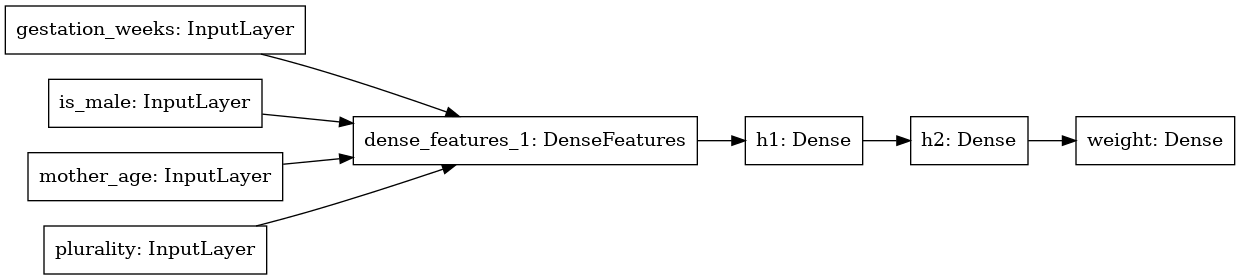

In [34]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

## Run and evaluate model

### Train and evaluate.

We've built our Keras model using our inputs from our CSV files and the architecture we designed. Let's now run our model by training our model parameters and periodically running an evaluation to track how well we are doing on outside data as training goes on. We'll need to load both our train and eval datasets and send those to our model through the fit method. Make sure you have the right pattern, batch size, and mode when loading the data.

**Lab Task #5:** Training and evaluating the model.

In [68]:
# TODO 5
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

# TODO -- Your code here.
train = load_dataset("*train*.csv", batch_size=TRAIN_BATCH_SIZE, mode="train")
valid = load_dataset("*eval*.csv", batch_size=1000).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

2022-05-05 16:18:21.909213: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-05 16:18:21.909267: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-05 16:18:21.910334: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


NameError: name 'trainds' is not defined

### Visualize loss curve

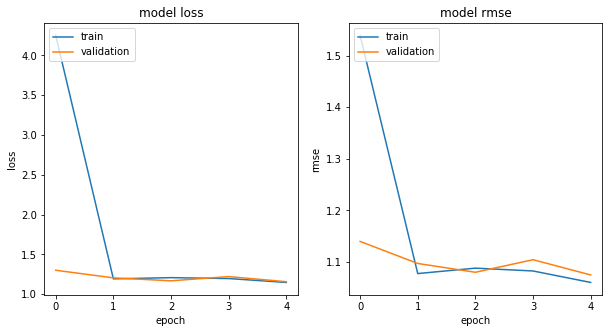

In [13]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

### Save the model

In [14]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(
    OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(
    obj=model, export_dir=EXPORT_PATH)  # with default serving function
print("Exported trained model to {}".format(EXPORT_PATH))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: babyweight_trained/20191119050541/assets
Exported trained model to babyweight_trained/20191119050541


In [15]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License